In [200]:
import pywren
import boto3
import pickle
import dill
from numpywren.matrix_utils import list_all_keys
import concurrent.futures as fs
import seaborn as sns
import numpywren.lambdapack as lp
from collections import defaultdict

In [201]:
PROGRAM_ID = "1536727565"
BUCKET = "numpywrennsdi"


In [202]:
s3_client = boto3.client("s3")

In [203]:
runtime_data = pickle.loads(s3_client.get_object(Bucket=BUCKET, Key="{0}/{1}/runtime.pickle".format("lambdapack", PROGRAM_ID))["Body"].read())

In [204]:
print(runtime_data["program"].program)

In [205]:
pywren_futures = runtime_data["all_futures"]

In [206]:
pywren.wait(pywren_futures)

AttributeError: 'list' object has no attribute '_state'

In [58]:
pywren_futures[0].result()

{'exec_time': [[1536727576.506405, 1536727714.1740148],
  [1536727714.272384, 1536727719.3701215]],
 'executed_messages': [[0, {'j': 48}],
  [0, {'j': 37}],
  [0, {'j': 12}],
  [2, {'j': 19, 'k': 88}],
  [2, {'j': 19, 'k': 93}],
  [2, {'j': 10, 'k': 56}],
  [2, {'j': 85, 'k': 48}],
  [2, {'j': 107, 'k': 62}],
  [2, {'j': 85, 'k': 106}],
  [2, {'j': 120, 'k': 51}],
  [2, {'j': 92, 'k': 48}],
  [2, {'j': 17, 'k': 109}],
  [2, {'j': 122, 'k': 97}],
  [2, {'j': 3, 'k': 100}],
  [2, {'j': 115, 'k': 112}],
  [2, {'j': 115, 'k': 97}],
  [2, {'j': 115, 'k': 95}],
  [2, {'j': 89, 'k': 63}],
  [2, {'j': 54, 'k': 1}],
  [2, {'j': 65, 'k': 47}],
  [2, {'j': 70, 'k': 60}],
  [2, {'j': 40, 'k': 90}],
  [2, {'j': 77, 'k': 63}],
  [2, {'j': 98, 'k': 114}],
  [2, {'j': 98, 'k': 123}],
  [2, {'j': 53, 'k': 67}],
  [2, {'j': 105, 'k': 101}],
  [2, {'j': 93, 'k': 17}],
  [2, {'j': 93, 'k': 76}],
  [2, {'j': 22, 'k': 56}],
  [2, {'j': 49, 'k': 73}],
  [2, {'j': 108, 'k': 19}],
  [2, {'j': 99, 'k': 99}],
  

In [62]:
pywren_futures = []
for f in runtime_data["all_futures"]:
    if (isinstance(f, list)):
        pywren_futures += f
    else:
        pywren_futures.append(f)
    

In [64]:
pywren_futures

In [66]:
runtime_data_dict = {}
for f in pywren_futures:
    for msg in f.result()['operator_refs']:
        runtime_data_dict[str(msg)] = f.result()

In [ ]:
s3_client = boto3.client("s3")

In [17]:
runtime_data = pickle.loads(s3_client.get_object(Bucket=BUCKET, Key="{0}/{1}/runtime.pickle".format("lambdapack", PROGRAM_ID))["Body"].read())

In [28]:
lst = [x for x in list_all_keys(bucket=BUCKET, prefix="{0}/{1}".format("lambdapack", PROGRAM_ID)) if "runtime" not in x]

In [29]:
def download_profiled_block(key, bucket):
    client = boto3.client('s3')
    return dill.loads(client.get_object(Key=key, Bucket=bucket)["Body"].read())


def perf_profile(blocks, num_bins=100):
    READ_INSTRUCTIONS = [lp.OC.S3_LOAD]
    WRITE_INSTRUCTIONS = [lp.OC.S3_WRITE, lp.OC.RET]
    COMPUTE_INSTRUCTIONS = [lp.OC.GENERIC]
    # first flatten into a single instruction list
    instructions_full = [inst for block in blocks for inst in block.instrs]
    instructions = [inst for block in blocks for inst in block.instrs if inst.end_time != None and inst.start_time != None]
    start_times = [inst.start_time for inst in instructions]
    end_times = [inst.end_time for inst in instructions]

    abs_start = min(start_times)
    last_end = max(end_times)
    tot_time = (last_end - abs_start)
    bins = np.linspace(0, tot_time, tot_time)
    total_flops_per_sec = np.zeros(len(bins))
    read_bytes_per_sec = np.zeros(len(bins))
    write_bytes_per_sec = np.zeros(len(bins))
    read_txns = np.zeros(len(bins))
    write_txns = np.zeros(len(bins))
    runtimes = []

    for i,inst in enumerate(instructions):
        if (inst.end_time == None or inst.start_time == None):
          # replay instructions don't always have profiling information...
          continue
        duration = inst.end_time - inst.start_time
        if (inst.i_code in READ_INSTRUCTIONS):
            start_time = inst.start_time - abs_start
            end_time = inst.end_time - abs_start
            start_bin, end_bin = np.searchsorted(bins, [start_time, end_time])
            size = inst.size
            bytes_per_sec = size/duration
            gb_per_sec = bytes_per_sec/1e9
            read_bytes_per_sec[start_bin:end_bin]  += gb_per_sec
            read_txns[start_bin:end_bin] += 1/duration

        if (inst.i_code in WRITE_INSTRUCTIONS):
            start_time = inst.start_time - abs_start
            end_time = inst.end_time - abs_start
            start_bin, end_bin = np.searchsorted(bins, [start_time, end_time])
            size = inst.size
            bytes_per_sec = size/duration
            gb_per_sec = bytes_per_sec/1e9
            write_bytes_per_sec[start_bin:end_bin]  += gb_per_sec
            write_txns[start_bin:end_bin] += 1/duration

        if (False and inst.i_code in COMPUTE_INSTRUCTIONS):
            start_time = inst.start_time - abs_start
            end_time = inst.end_time - abs_start
            start_bin, end_bin = np.searchsorted(bins, [start_time, end_time])
            flops = inst.flops
            flops_per_sec = flops/duration
            gf_per_sec = flops_per_sec/1e9
            total_flops_per_sec[start_bin:end_bin]  += gf_per_sec
        runtimes.append(duration)
    optimes = defaultdict(int)
    opcounts = defaultdict(int)
    computetimes = defaultdict(int)
    computecounts = defaultdict(int)
    offset = instructions[0].start_time
    for inst, t in zip(instructions, runtimes):
      opcounts[inst.i_code] += 1
      optimes[inst.i_code] += t
      if (inst.i_code in COMPUTE_INSTRUCTIONS):
        computetimes[inst.compute] += t
        computecounts[inst.compute] += 1
      IO_INSTRUCTIONS = [lp.OC.S3_LOAD, lp.OC.S3_WRITE, lp.OC.RET]
    print("Average instruction runtimes:")
    for k in optimes.keys():
      print("{0}: {1}s".format(k, optimes[k]/opcounts[k]))
    print("Average Compute runtimes:")
    for k in computetimes.keys():
      print("{0}: {1}s".format(k, computetimes[k]/computecounts[k]))
    return read_txns, write_txns, read_bytes_per_sec, write_bytes_per_sec, total_flops_per_sec, bins , instructions, runtimes



In [30]:
lst

['lambdapack/1536727565/0013455337e993db34575e547eaa7e06',
 'lambdapack/1536727565/0163e3a97afffca5ee6116c493aa1129',
 'lambdapack/1536727565/01baf539686ded5c31bc2fe1925d8aa3',
 'lambdapack/1536727565/01e81651c05c4a929c9ed684c814b6ed',
 'lambdapack/1536727565/0222728b766deac35425fc266b527b10',
 'lambdapack/1536727565/02302193115a6cf8203e7af40e1c4dd3',
 'lambdapack/1536727565/0348743f5c336248dfefb6f94b1dda57',
 'lambdapack/1536727565/03576a96c2c2ccf11e816457618888e2',
 'lambdapack/1536727565/03aa1d79de9548cd8400f369964b25d8',
 'lambdapack/1536727565/03d001d884aa48ef161a65bcf1525e0c',
 'lambdapack/1536727565/04367050dde88e35cfb0fdaacd43f83d',
 'lambdapack/1536727565/04f0bbf4e96683ffbc3a3d18e719d9ae',
 'lambdapack/1536727565/04f6c8d0432ac908e9d35fece3dc0cd2',
 'lambdapack/1536727565/05153de6d882cb7a1b334c218a2aa7d2',
 'lambdapack/1536727565/05264f18f5f7d7355cfcdcd98a39e0d3',
 'lambdapack/1536727565/05e36a347be96bb5135b323caf6ee60d',
 'lambdapack/1536727565/064e8eb6db89214cfc6dd4075bd59381

In [39]:
 
executor = fs.ThreadPoolExecutor(64)
futures = []
for key in lst:
    futures.append(executor.submit(download_profiled_block, key, BUCKET))
res = fs.wait(futures)

In [40]:
profiled_blocks = {}
for f in futures:
    try:
        for k,v in f.result().items():
            profiled_blocks[str(k)] = pickle.loads(v)
    except:
        pass

In [61]:
profiled_blocks

{"(2, {'k': 119, 'j': 94})": <numpywren.lambdapack.InstructionBlock at 0x7fb168604518>,
 "(2, {'k': 60, 'j': 123})": <numpywren.lambdapack.InstructionBlock at 0x7fb168604048>,
 "(2, {'k': 64, 'j': 9})": <numpywren.lambdapack.InstructionBlock at 0x7fb1686046d8>,
 "(2, {'k': 121, 'j': 47})": <numpywren.lambdapack.InstructionBlock at 0x7fb051ace4a8>,
 "(2, {'k': 62, 'j': 76})": <numpywren.lambdapack.InstructionBlock at 0x7fb168604400>,
 "(2, {'k': 109, 'j': 57})": <numpywren.lambdapack.InstructionBlock at 0x7fb1685cc518>,
 "(3, {'level': 0, 'j': 62, 'k': 82})": <numpywren.lambdapack.InstructionBlock at 0x7fb1685cc940>,
 "(3, {'level': 0, 'j': 2, 'k': 126})": <numpywren.lambdapack.InstructionBlock at 0x7fb168604b38>,
 "(3, {'level': 0, 'j': 16, 'k': 4})": <numpywren.lambdapack.InstructionBlock at 0x7fb1686049e8>,
 "(3, {'level': 0, 'j': 20, 'k': 75})": <numpywren.lambdapack.InstructionBlock at 0x7fb1486a4278>,
 "(3, {'level': 0, 'j': 114, 'k': 32})": <numpywren.lambdapack.InstructionBlock 

In [25]:
profiled_blocks_flat = [pickle.loads(b) for x in profiled_blocks for b in x.values()]

In [21]:
 profiled_blocks_flat[0].instrs[-1].end_time - profiled_blocks_flat[0].instrs[0].start_time

5.344607591629028

In [27]:
profiled_blocks

{}

In [67]:
runtime_data_dict

{"(0, {'j': 37})": {'exec_time': [[1536727576.506405, 1536727714.1740148],
   [1536727714.272384, 1536727719.3701215]],
  'executed_messages': [[0, {'j': 48}],
   [0, {'j': 37}],
   [0, {'j': 12}],
   [2, {'j': 19, 'k': 88}],
   [2, {'j': 19, 'k': 93}],
   [2, {'j': 10, 'k': 56}],
   [2, {'j': 85, 'k': 48}],
   [2, {'j': 107, 'k': 62}],
   [2, {'j': 85, 'k': 106}],
   [2, {'j': 120, 'k': 51}],
   [2, {'j': 92, 'k': 48}],
   [2, {'j': 17, 'k': 109}],
   [2, {'j': 122, 'k': 97}],
   [2, {'j': 3, 'k': 100}],
   [2, {'j': 115, 'k': 112}],
   [2, {'j': 115, 'k': 97}],
   [2, {'j': 115, 'k': 95}],
   [2, {'j': 89, 'k': 63}],
   [2, {'j': 54, 'k': 1}],
   [2, {'j': 65, 'k': 47}],
   [2, {'j': 70, 'k': 60}],
   [2, {'j': 40, 'k': 90}],
   [2, {'j': 77, 'k': 63}],
   [2, {'j': 98, 'k': 114}],
   [2, {'j': 98, 'k': 123}],
   [2, {'j': 53, 'k': 67}],
   [2, {'j': 105, 'k': 101}],
   [2, {'j': 93, 'k': 17}],
   [2, {'j': 93, 'k': 76}],
   [2, {'j': 22, 'k': 56}],
   [2, {'j': 49, 'k': 73}],
   [2,

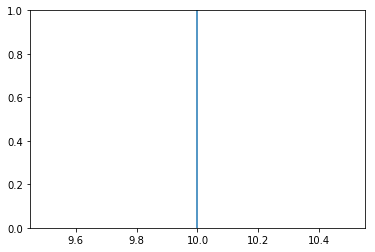

In [279]:

start_read = []
end_read = []

start_compute = []
end_compute = []

start_write = []
end_write = []


for j in range(1):
    blocks_in_run = []
    for op in pywren_futures[j].result()['operator_refs']:
        blocks_in_run.append(profiled_blocks[str(op)])
    blocks_in_run = sorted(blocks_in_run, key=lambda x: x.instrs[0].start_time)
    bins = list(range(int(blocks_in_run[0].start_time), int(blocks_in_run[-1].end_time)))
    reading_time = np.zeros(len(bins))
    writing_time = np.zeros(len(bins))
    computing_time = np.zeros(len(bins))
    
    starts = []
    ends = []
    rts = []
    rts_without_postop = []
    tot_reads = []
    tot_writes = []
    tot_computes = []
    tot_read_times = []
    tot_compute_times = []
    tot_write_times = []
    read_instrs = []
    compute_instrs = []
    write_instrs = []
    
    print("==="*3 + "WORKER {0}".format(j) + "==="*3)
    for i,b in enumerate(blocks_in_run):
        
        free_time = 0
        starts.append((b.start_time, i))
        ends.append((b.post_op_end, i))
        rts.append((b.post_op_end - b.start_time))
        rts_without_postop.append((b.instrs[-1].end_time - b.start_time))
        curr = starts[-1][0]
        reads = 0
        writes = 0
        computes = 0
        read_time = 0
        write_time = 0
        compute_time = 0
        read_times_start = []
        write_times_start = []
        compute_times_start = []
        
        read_times_end = []
        write_times_end = []
        compute_times_end = []
        free_time = [y.end_time - x.start_time for x,y in zip(b.instrs[:-1], b.instrs[1:])]
        for inst in b.instrs:
            curr = inst.end_time
            duration = inst.end_time - inst.start_time
            start_bin, end_bin = np.searchsorted(bins, [inst.start_time, inst.end_time]) 
            if isinstance(inst, lp.RemoteRead):
                read_instrs.append(inst)
                reads += 1
                read_time += inst.end_time - inst.start_time
                reading_time[start_bin:end_bin] += 1
            elif isinstance(inst, lp.RemoteWrite):
                write_instrs.append(inst)
                writes += 1
                write_time += inst.end_time - inst.start_time
                write_times_start.append(inst.start_time)
                write_times_end.append(inst.end_time)
                writing_time[start_bin:end_bin] += 1
            elif isinstance(inst, lp.RemoteCall):
                compute_instrs.append(inst)
                computes += 1
                compute_time += inst.end_time - inst.start_time
                compute_times_start.append(inst.start_time)
                compute_times_end.append(inst.end_time)
                computing_time[start_bin:end_bin] += 1
        tot_reads.append(reads)
        tot_writes.append(writes)
        tot_computes.append(computes)
        tot_read_times.append(read_time)
        tot_write_times.append(write_time)
        tot_compute_times.append(compute_time)
        #print("free time", free_time)
        #print("free time frac", free_time/(ends[-1][0] - starts[-1][0]))
        
            
    print("Average num reads", np.mean(tot_reads))
    print("Average num writes", np.mean(tot_writes))
    print("Average num computes", np.mean(tot_computes))
    print("Average block completion time", np.mean(rts))
    print("Average block completion time without postop", np.mean(rts_without_postop))
    
    print("Average read times", np.mean(tot_read_times))
    print("Average compute times ", np.mean(tot_compute_times))
    print("Average write times", np.mean(tot_write_times))
    print("Variance read times", np.std(tot_read_times))
    print("Variance compute times ", np.std(tot_compute_times))
    print("Variance write times", np.std(tot_write_times))
    print("Average total real work", np.mean(tot_read_times) + np.mean(tot_compute_times) + np.mean(tot_write_times))
    print("Average total read + compute", np.mean(tot_read_times) + np.mean(tot_compute_times))
    
    


=========WORKER 0=========
Average num reads 2.8461538461538463
Average num writes 1.1538461538461537
Average num computes 1.0
Average block completion time 10.091740932220068
Average block completion time without postop 8.475051244099935
Average read times 3.3869167535732956
Average compute times  2.009346925295316
Average write times 2.543077536118336
Variance read times 3.466324502445163
Variance compute times  0.3252057158642663
Variance write times 5.550202722425609
Average total real work 7.939341214986948
Average total read + compute 5.396263678868612


In [284]:
read_instrs = sorted(read_instrs, key=lambda x: x.start_time)

In [312]:
read_free_time =  [y.end_time - x.start_time for x,y in zip(read_instrs[:-1], read_instrs[1:])]

In [313]:
read_free_time = np.array(read_free_time)

In [314]:
np.mean(read_free_time[read_free_time < 8])

1.7502925800827314

In [306]:
compute_instrs = sorted(compute_instrs, key=lambda x: x.start_time)

In [307]:
compute_free_time =  [y.end_time - x.start_time for x,y in zip(compute_instrs[:-1], compute_instrs[1:])]

In [308]:
compute_free_time = np.array(compute_free_time)

In [315]:
compute_free_time

array([ 2.97062254,  2.19464898, 52.36535454,  4.73372102,  4.12420893,
        4.89641929,  4.21664214,  4.49760342,  4.02789426,  5.51888871,
        4.63388658,  4.74076819,  5.66163492,  4.00895739,  3.64861345,
        4.70997953,  4.23465466,  4.17887998,  4.67289996,  4.29394031,
        3.82842922,  4.47321248,  5.37540078,  4.40751624,  4.2623539 ,
        5.41841578,  4.14035034,  3.99595809,  5.57399631,  4.12194657,
        4.10512733,  4.43020892,  3.99218559,  3.5675962 ,  4.70353961,
        4.07731223,  3.91989446,  7.25094438])

In [309]:
sns.tsplot(reading_time[start:end], time=(bins - min(bins))[start:end], color="green")
#sns.tsplot(computing_time[60:80], time=(bins - min(bins))[60:80], color="red")
#sns.tsplot(writing_time[60:80], time=(bins - min(bins))[60:80])

TypeError: unsupported operand type(s) for -: 'list' and 'int'

/home/ubuntu/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


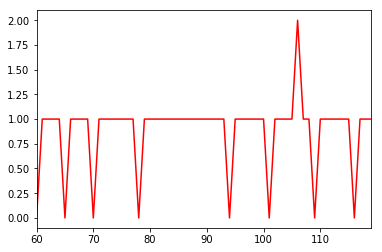

In [268]:
sns.tsplot(computing_time[start:end], time=(bins - min(bins))[start:end], color="red")

/home/ubuntu/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


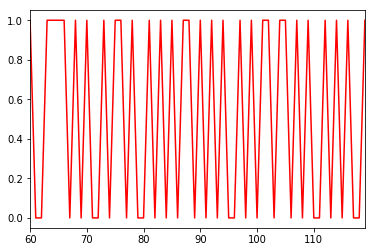

In [269]:
sns.tsplot(writing_time[start:end], time=(bins - min(bins))[start:end], color="red")

(array([35.,  0.,  0.,  0.,  1.,  2.,  0.,  0.,  0.,  1.]),
 array([ 4.61301804,  7.67913339, 10.74524875, 13.8113641 , 16.87747946,
        19.94359481, 23.00971017, 26.07582552, 29.14194088, 32.20805624,
        35.27417159]),
 <a list of 10 Patch objects>)

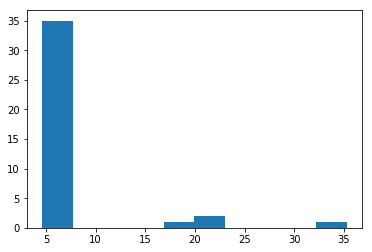

In [199]:
#plt.hist(rts)
plt.hist(np.array(tot_read_times) + np.array(tot_compute_times) + np.array(tot_write_times))

(600, 700)

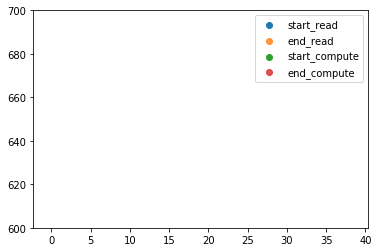

In [242]:
plt.scatter(*zip(*start_read), label="start_read")
plt.scatter(*zip(*end_read), label="end_read", alpha=0.8)

plt.scatter(*zip(*start_compute), label="start_compute")
plt.scatter(*zip(*end_compute), label="end_compute", alpha=0.8)
plt.legend()
#plt.xlim(15,20)
plt.ylim(600,700)

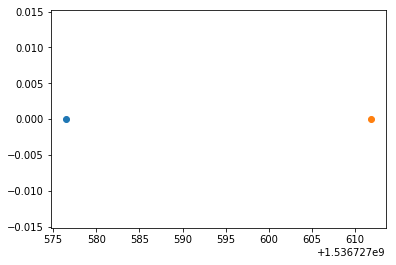

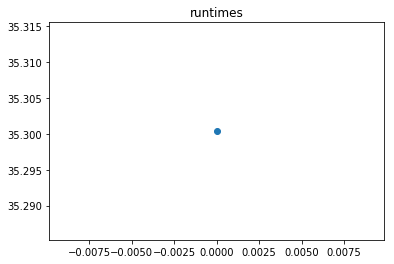

In [163]:
plt.scatter(*zip(*starts))
plt.scatter(*zip(*ends))
plt.figure()
plt.title("runtimes")
plt.scatter(*zip(*rts))

In [139]:

plt.scatter()

TypeError: scatter() missing 2 required positional arguments: 'x' and 'y'

In [131]:
fig.axes


[]

In [244]:
np.searchsorted([1,8,9,10], 3)

1